In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip = True,
    rotation_range = 10
)
train_generator = train_datagen.flow_from_directory(
    'dataset/train',
    target_size = (256,256),
    batch_size = 32,
    class_mode = 'sparse'
)

Found 1506 images belonging to 3 classes.


In [11]:
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip = True,
    rotation_range = 10
)
validation_generator = train_datagen.flow_from_directory(
    'dataset/val',
    target_size = (256,256),
    batch_size = 32,
    class_mode = 'sparse'
)
input_shape = (256,256,3)

Found 215 images belonging to 3 classes.


In [7]:
test_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip = True,
    rotation_range = 10
)
test_generator = train_datagen.flow_from_directory(
    'dataset/test',
    target_size = (256,256),
    batch_size = 32,
    class_mode = 'sparse'
)

Found 431 images belonging to 3 classes.


In [7]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
"PlantVillage",
shuffle=True, #every time dataset is accesed all images are shuffled
 image_size = (img_size,img_size),
    batch_size=b_size #size of every element in dataset
)

Found 2152 files belonging to 3 classes.


In [8]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [103]:
len(dataset)

68

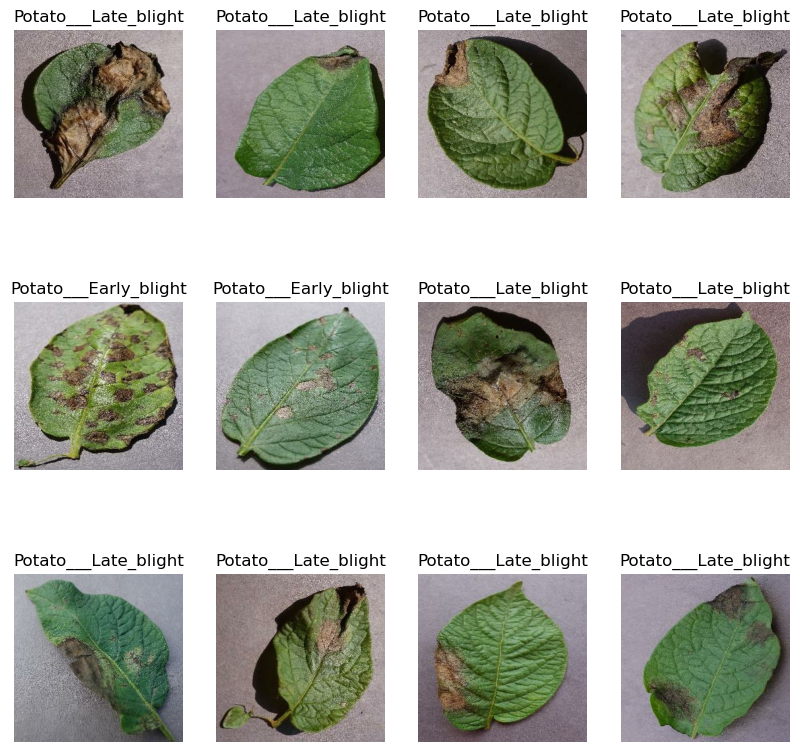

In [26]:
plt.figure(figsize=(10,10)) #Used to increase figure size
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])
#         print(image_batch.shape)
#         print(label_batch.numpy().shape)

In [28]:
len(dataset)*0.8

54.400000000000006

In [31]:
train_ds = dataset.take(54)
len(train_ds)
len(dataset)*0.1

6.800000000000001

In [34]:
rest_ds = dataset.skip(54) #tensor equivalent of arr[54:]
val_ds = rest_ds.take(6)
test_ds = rest_ds.skip(6)

In [104]:
len(test_ds)

54

In [42]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds.shuffle(shuffle_size,seed=7)
    train_size=int(ds_size*train_split)
    test_size = int(ds_size*test_split)
    val_size = int(ds_size*val_split)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size) 
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds

In [43]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)
len(test_ds)

8

In [45]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) # cache() saves all data read in one epoch so that in future epochs it won't have to read
#the data once again, hence optimising process
#prefetch() loads next batch of data while current one is running and hence optimises time.
val_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [46]:
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(img_size,img_size),
    layers.experimental.preprocessing.Rescaling(1.0/255),
    
])

In [47]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [12]:
n_classes = 3
model = models.Sequential([
    #layers.InputLayer(input_shape=input_shape),
    resize_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax') #Softmax normalises probability of classes.
])
model.build(input_shape=input_shape)

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 64)        0

In [14]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [15]:
1506/32

47.0625

In [64]:
history =  model.fit(train_ds,epochs=epochs,batch_size=b_size,verbose=1,validation_data=val_ds) 

Epoch 1/50
54/54 [==============================] - 117s 2s/step - loss: 0.5684 - accuracy: 0.7459 - val_loss: 0.3606 - val_accuracy: 0.8519
Epoch 2/50
54/54 [==============================] - 106s 2s/step - loss: 0.3676 - accuracy: 0.8490 - val_loss: 0.3718 - val_accuracy: 0.8385
Epoch 3/50
54/54 [==============================] - 106s 2s/step - loss: 0.3104 - accuracy: 0.8686 - val_loss: 0.2189 - val_accuracy: 0.9016
Epoch 4/50
54/54 [==============================] - 106s 2s/step - loss: 0.2675 - accuracy: 0.8872 - val_loss: 0.1819 - val_accuracy: 0.9352
Epoch 5/50
54/54 [==============================] - 107s 2s/step - loss: 0.2371 - accuracy: 0.9207 - val_loss: 0.1842 - val_accuracy: 0.9225
Epoch 6/50
54/54 [==============================] - 106s 2s/step - loss: 0.2453 - accuracy: 0.8999 - val_loss: 0.1915 - val_accuracy: 0.9138
Epoch 7/50
54/54 [==============================] - 105s 2s/step - loss: 0.1646 - accuracy: 0.9416 - val_loss: 0.1743 - val_accuracy: 0.9323
Epoch 8/50
54

In [65]:
score = model.evaluate(test_ds)

54/54 [==============================] - 15s 265ms/step - loss: 0.0144 - accuracy: 0.9954


In [66]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [69]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

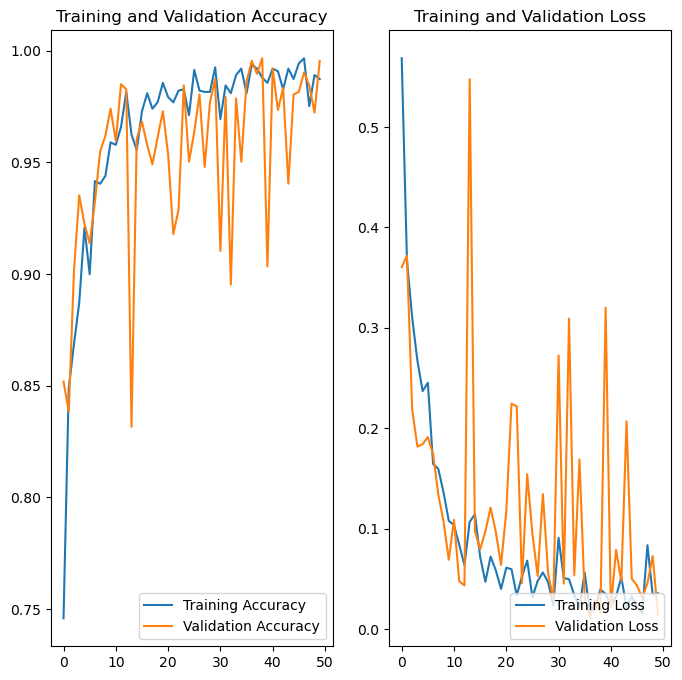

In [90]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(epochs),acc,label='Training Accuracy')
plt.plot(range(epochs),val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(epochs),loss,label='Training Loss')
plt.plot(range(epochs),val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
first image's actual label:  Potato___Late_blight
1/1 [==============================] - 0s 301ms/step
first image's actual label:  Potato___Late_blight


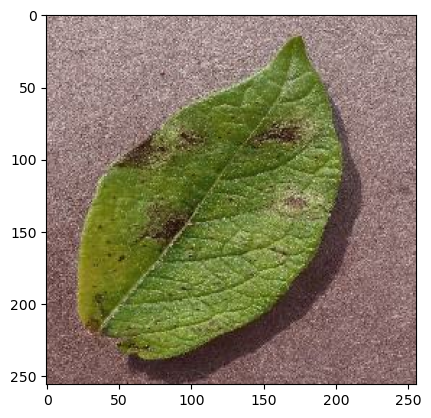

In [91]:
for images_batch,label_batch in test_ds.take(1):
    first_image = (images_batch[0].numpy().astype('uint8'))
    first_label = label_batch[0]
    
    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label: ",class_names[first_label.numpy()])
    batch_prediction = model.predict(images_batch)
    print("first image's actual label: ",class_names[np.argmax(batch_prediction[0])])
    

In [98]:
def predict(model,img):
    img_arr = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_arr = tf.expand_dims(img_arr,0) # Create a Batch
    
    predictions = model.predict(img_arr)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class , confidence

1/1 [==============================] - 0s 43ms/step


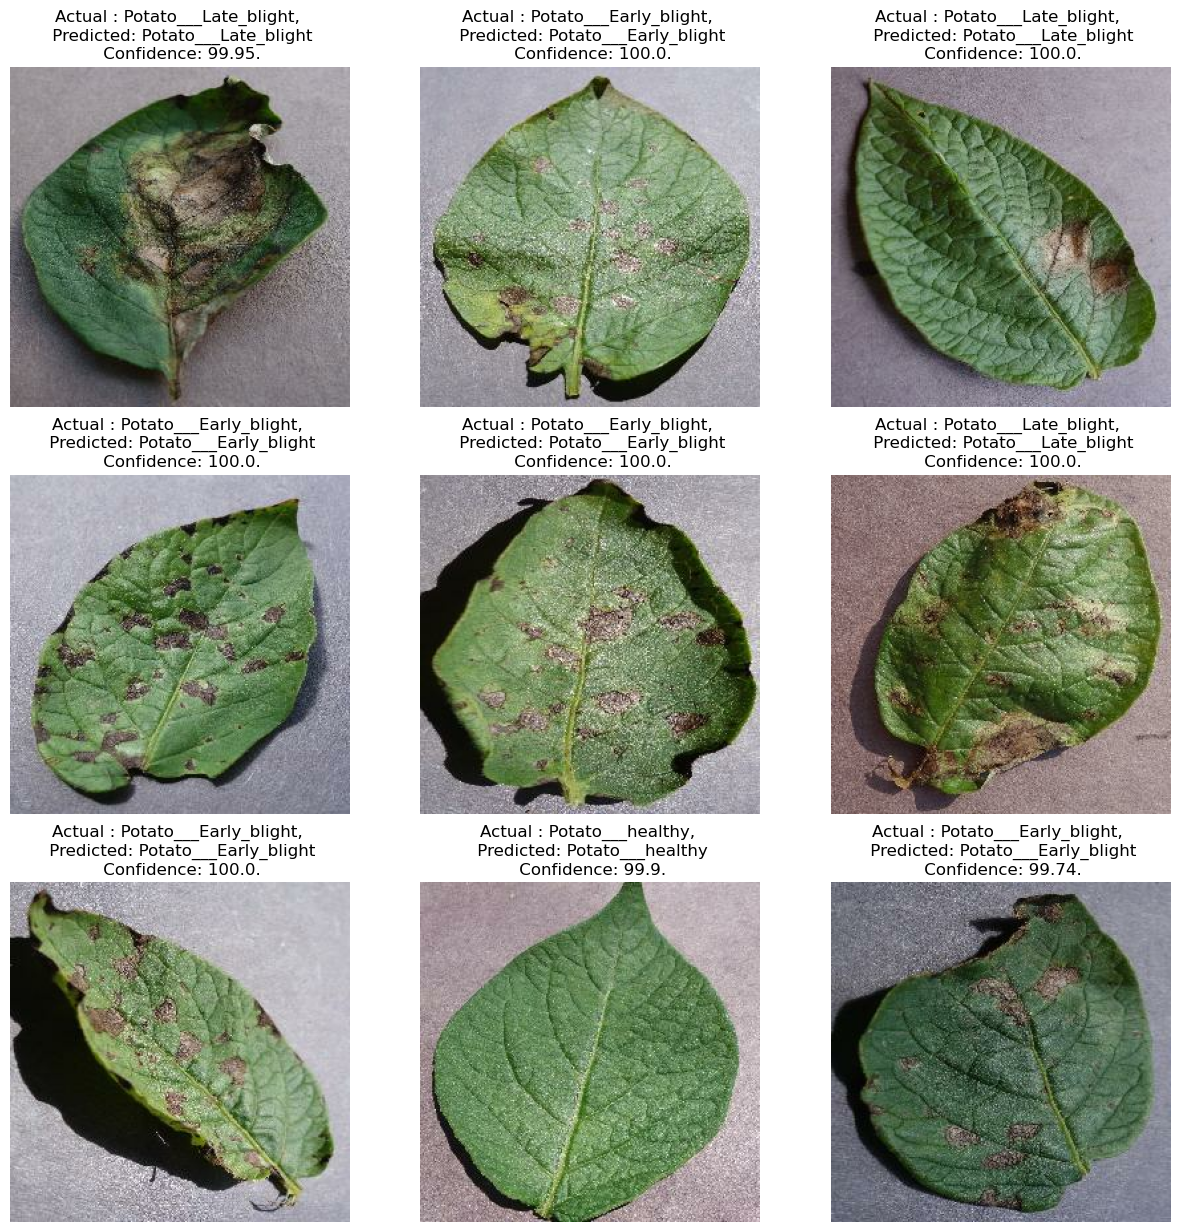

In [100]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class,confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual : {actual_class}, \n Predicted: {predicted_class}\n Confidence: {confidence}.")
        plt.axis("off")

In [101]:
model_version=1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


In [102]:
import os
os.listdir("../models")

['1']

In [105]:
print(tf.__version__)

2.13.0


In [ ]:
history =  model.fit(train_generator,steps_per_epoch=47,batch_size=b_size,verbose=1,validation_data=validation_generator,validation_steps=6,verbose=1,epochs=20) 